In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['HDF5_DISABLE_VERSION_CHECK']='1'

In [2]:
#import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers.convolutional import MaxPooling2D
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from tqdm import tqdm
import cv2
from keras.callbacks import EarlyStopping
from keras.applications import ResNet50
from keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.python.keras.models import Sequential
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model


# 訓練用的超參數
batch_size = 32  
epochs = 5
data_augmentation = True
num_classes = 5
IMG_SIZE=256
# Early Stopping
PATIENCE = 3  
# Learning Rate Reduction
REDUCE_LR_FACTOR = 0.5  
REDUCE_LR_PATIENCE = 3    
# Optimizer
LEARNING_RATE = 0.001
# 資料標準化的方式，此處使用減去所有影像的平均值
subtract_pixel_mean = False

D:\Users\user\anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:37: UserWarning: h5py is running against HDF5 1.10.5 when it was built against 1.10.4, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [3]:
#讀取資料集
train_folder = os.listdir('D101_exam/image_data/train/')

In [4]:
categories = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
flower_mapping = {'daisy':0, 'dandelion':1, 'rose':2, 'sunflower':3, 'tulip':4} 

In [5]:
train_data = []
lebal_data =[]
test_data = []
DAISY_DIR='D101_exam/image_data/train/daisy'
SUNFLOWER_DIR='D101_exam/image_data/train/sunflower'
TULIP_DIR='D101_exam/image_data/train/tulip'
DANDI_DIR='D101_exam/image_data/train/dandelion'
ROSE_DIR='D101_exam/image_data/train/rose'
TEST_DIR='D101_exam/image_data/test'

In [6]:
def resize_image(image, height, width):
     top, bottom, left, right = (0, 0, 0, 0)

     #取得圖片
     h, w, _ = image.shape

     #以最長的邊長為準
     longest_edge = max(h, w)    

     #補足邊長
     if h < longest_edge:
         dh = longest_edge - h
         top = dh // 2
         bottom = dh - top
     elif w < longest_edge:
         dw = longest_edge - w
         left = dw // 2
         right = dw - left
     else:
         pass 

     #RGB颜色
     BLACK = [0, 0, 0]

     #增加圖片邊界
     constant = cv2.copyMakeBorder(image, top , bottom, left, right, cv2.BORDER_CONSTANT, value = BLACK)

     #調整大小
     return cv2.resize(constant, (height, width))

(256, 256, 3)


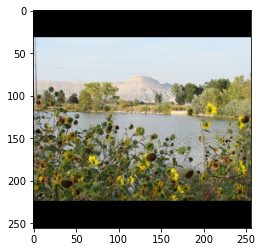

In [25]:
img = cv2.imread('D101_exam/image_data/train/sunflower/1bde08d0fefbe05e0b416277184e12ff.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = resize_image(img, 256,256)
plt.imshow(img)
print(img.shape)

In [8]:
#把類別和照片組合
def assigning_label(img,flower_type):
    return flower_type

In [9]:
#組合成訓練資料集
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assigning_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = resize_image(img, IMG_SIZE,IMG_SIZE)
        
        train_data.append(np.array(img))
        lebal_data.append(str(label))

In [10]:
#create training data
make_train_data('daisy',DAISY_DIR)
make_train_data('dandelion',DANDI_DIR)
make_train_data('rose',ROSE_DIR)
make_train_data('sunflower',SUNFLOWER_DIR)
make_train_data('tulip',TULIP_DIR)
test_data = os.listdir(TEST_DIR)
print(len(train_data))
print(len(test_data))

100%|███████████████████████████████████████████████████████████████████████████████| 984/984 [00:04<00:00, 201.68it/s]

4323
2000


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#標準化資料與LabelEncoder
le=LabelEncoder()
lebal_data=le.fit_transform(lebal_data)
lebal_data=keras.utils.to_categorical(lebal_data,num_classes)
#train_data=np.array(train_data, dtype="float")/255 記憶體不夠無法用np.array
print(list(le.classes_))
integer_mapping = {l: i for i, l in enumerate(le.classes_)}
print(integer_mapping)
#切割訓練和驗證資料 這邊會手動調整random seed做cross validation
x_train,x_val,y_train,y_val=train_test_split(train_data,lebal_data,test_size=0.2,random_state=43)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


In [12]:
#避免特定種類資料過於集中 重新打散資料
seed = 100
np.random.seed(seed)
np.random.shuffle(x_train)
np.random.seed(seed)
np.random.shuffle(y_train)
np.random.seed(seed)
np.random.shuffle(x_val)
np.random.seed(seed)
np.random.shuffle(y_val)

In [13]:
# 再減去所有影像的平均值
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean 
    x_val -= x_train_mean # 此處要注意！測試資料也是減去訓練資料的平均值來做標準化，不可以減測試資料的平均值 (因為理論上你是不能知道測試資料的平均值的！)

In [14]:
#因應記憶體不足切分資料之後再重新轉成np.array
x_train = np.array(x_train, dtype="float")
x_val = np.array(x_val, dtype="float")
# 影像輸入的維度
input_shape = x_train.shape[1:]

In [15]:
# 學習率動態調整。當跑到第幾個 epcoh 時，根據設定修改學習率。這邊的數值都是參考原 paper
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = LEARNING_RATE
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [16]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam


model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', input_shape=input_shape, activation='relu', name='conv_1'))
model.add(Conv2D(32, (3,3), activation='relu', name='conv_2'))
model.add(MaxPooling2D(pool_size=(2,2), name='maxpool_1'))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding='same', activation='relu', name='conv_3'))
model.add(Conv2D(64, (3,3), activation='relu', name='conv_4'))
model.add(MaxPooling2D(pool_size=(2,2), name='maxpool_2'))
model.add(Dropout(0.25))
    
model.add(Conv2D(128, (3,3), padding='same', activation='relu', name='conv_5'))
model.add(Conv2D(128, (3,3), activation='relu', name='conv_6'))
model.add(MaxPooling2D(pool_size=(2,2), name='maxpool_3'))

model.add(Flatten())
model.add(Dense(512, activation='relu', name='dense_1'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', name='dense_2'))
model.add(Dense(len(categories), name='output'))
model.add(Activation('softmax'))

model.compile( loss = 'categorical_crossentropy', optimizer = Adam( lr = LEARNING_RATE ), metrics = [ 'accuracy' ])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 254, 254, 32)      9248      
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 127, 127, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 32)      0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 127, 127, 64)      18496     
_________________________________________________________________
conv_4 (Conv2D)              (None, 125, 125, 64)      36928     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 62, 62, 64)        0

In [18]:
# 使用動態調整學習率
lr_scheduler = LearningRateScheduler(lr_schedule)

# 使用自動降低學習率 (當 validation loss 連續 5 次沒有下降時，自動降低學習率)
lr_reducer = ReduceLROnPlateau(factor=0.5,
                               monitor = 'val_accuracy', 
                               patience=PATIENCE)



earlystop = EarlyStopping( monitor = 'val_accuracy', 
                           patience = PATIENCE,  # 容忍訓練無再改善時的 EPOCHS 次數
                           verbose = 1
                        )

model_ckpt_weight = ModelCheckpoint(filepath="./tmpcnn2_weight17.h5", 
                             monitor="val_accuracy", 
                             save_weights_only=True)

model_ckpt_model = ModelCheckpoint(filepath="./tmpcnn2_model17.h5", 
                             monitor="val_accuracy", 
                             save_best_only=True)


# 設定 callbacks 依需求加入需要的callback
callbacks = [model_ckpt_weight,model_ckpt_model]

#依照需求記憶model
#model = keras.models.load_model("./tmpcnn2_model16.h5")

print('Using real-time data augmentation.')
# 將資料送進 ImageDataGenrator 中做增強
train_datagen  = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(
rescale=1./255)

train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=batch_size
)

val_generator = val_datagen.flow(
    x_val,
    y_val,
    batch_size=batch_size
)



Using real-time data augmentation.


In [19]:
# 訓練模型
model.fit_generator(generator=train_generator,
            steps_per_epoch=int(len(x_train)/batch_size),
            validation_data=val_generator,
            validation_steps=len(x_val)/batch_size,
            epochs=epochs, verbose=1, workers=4,
            callbacks=callbacks)

model.save("final_model17.h5")
model.save_weights("model_weights17.h5")

# 評估我們的模型
scores = model.evaluate(x_val, y_val, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
108/108 [==============================] - 476s 4s/step - loss: 0.4345 - accuracy: 0.8427 - val_loss: 0.7039 - val_accuracy: 0.7919
Epoch 2/5
108/108 [==============================] - 468s 4s/step - loss: 0.4354 - accuracy: 0.8336 - val_loss: 0.7022 - val_accuracy: 0.7919
Epoch 3/5
108/108 [==============================] - 482s 4s/step - loss: 0.4493 - accuracy: 0.8430 - val_loss: 0.7851 - val_accuracy: 0.7723
Epoch 4/5
108/108 [==============================] - 527s 5s/step - loss: 0.4486 - accuracy: 0.8322 - val_loss: 0.7191 - val_accuracy: 0.8058
Epoch 5/5
28/28 [==============================] - 37s 1s/step - loss: 414.0361 - accuracy: 0.4890
Test loss: 414.0361328125
Test accuracy: 0.4890173375606537


In [21]:
import pandas as pd
import numpy as np
from keras.preprocessing import image
import cv2
model = keras.models.load_model("./tmpcnn2_model16.h5")
submit = pd.DataFrame(columns=['id', 'flower_class'])

TEST_DIR='D101_exam/image_data/test'
test_data = os.listdir(TEST_DIR)
# predict all photos
for idx, imgs in enumerate(test_data):
    path = os.path.join(TEST_DIR,imgs)
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    if img is None :
        continue
    img = resize_image(img, IMG_SIZE,IMG_SIZE)
    # Converts a PIL Image instance to a Numpy array. shape=(IMG_SIZE, IMG_SIZE, 3)
    img_data = np.array(img, dtype="float") /255
    # Insert a new axis that will appear at the `axis` position in the expanded array shape. shape=(1, IMG_SIZE, IMG_SIZE, 3)
    img_data = np.expand_dims(img_data, axis=0)   
    
    
    predict = model.predict(img_data)
    submit.loc[idx] = [imgs.split('.')[0], predict.argmax()]

submit.to_csv('Day101_submission_v21.csv', index=False)

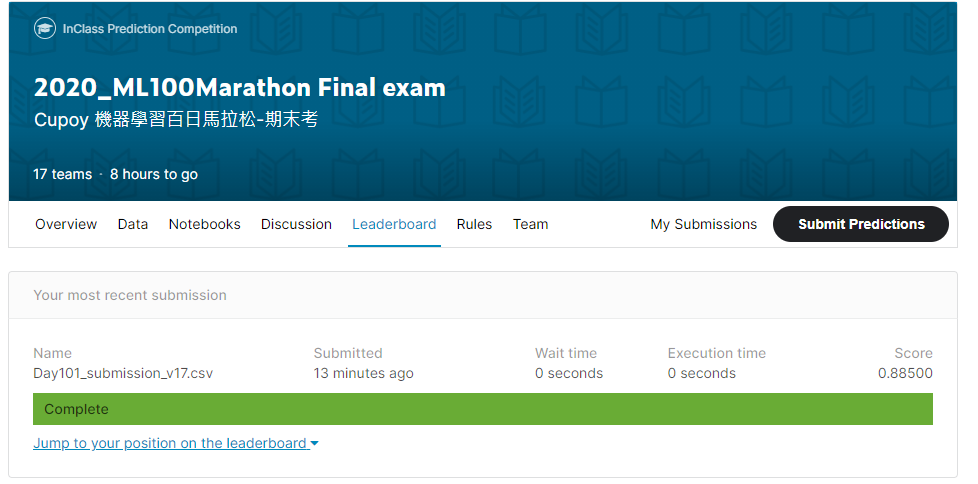

In [29]:
#期限前最終成績
from IPython.display import Image
Image("final_exam.PNG")